使用許諾条件

①	設計一次エネルギー消費量算定法に基づく計算方法をPythonによりコーディングし、Jupyter notebook形式で保存したファイル（以下、本ファイルと呼ぶ）の著作権は、一般社団法人日本サステナブル建築協会に帰属します。
Copyright©2019. 一般社団法人日本サステナブル建築協会
All rights reserved. 

②	本ファイルは、住戸の設計一次エネルギー消費量算定方法に係る「平成28年省エネルギー基準に準拠したエネルギー消費性能の評価に関する技術情報（住宅）2.1算定方法（第五章 換気設備）」に示す計算方法に基づき、国土交通省国土技術政策総合研究所・国立研究開発法人建築研究所、株式会社ユーワークス、株式会社住環境計画研究所が作成したものです。

③	本ファイルは、計算方法に示す計算過程の確認及び調査研究等に活用することを目的として作成されたものであり、一般社団法人日本サステナブル建築協会は著作権について放棄はしませんが、使用する各人の自己責任において仕様を変更することを妨げるものではありません。ただし、本ファイルによる計算結果を住宅の省エネルギー基準で規定する設計一次エネルギー消費量の結果として公的な申請に用いることはできません。

④	本ファイルを変更するかしないかを問わず、以下の条件を満たす場合に限り、頒布および使用が許可されます。
1.	頒布物の付属ドキュメント等の資料に、上記の著作権表示、本条件一覧、および下記免責条項を含めること。
2.	書面による特別の許可なしに、本ファイルから派生した製品の宣伝または販売の促進に、一般社団法人日本サステナブル建築協会、国土技術政策総合研究所・国立研究開発法人建築研究所および株式会社ユーワークス、株式会社住環境計画研究所の名前またはコントリビューターの名前を使用してはならない。

⑤	本ファイルは、著作権者およびコントリビューターによって「現状のまま」提供されており、明示黙示を問わず、商業的な使用可能性、および特定の目的に対する適合性に関する暗黙の保証も含め、またそれに限定されない、いかなる保証もありません。著作権もコントリビューターも、事由のいかんを問わず、損害発生の原因いかんを問わず、かつ責任の根拠が契約であるか厳格責任であるか（過失その他の）不法行為であるかを問わず、仮にそのような損害が発生する可能性を知らされていたとしても、本ファイルの使用によって発生した（代用品または代用サービスの調達、使用の喪失、データの喪失、利益の喪失、業務の中断も含め、またそれに限定されない）直接損害、間接損害、偶発的な損害、特別損害、懲罰的損害、または結果損害について、一切の責任を負わないものとします。

In [1]:
import nbimporter
import numpy as np
from math import ceil
from s11_03_life_schedule import load_schedule, get_schedule_v

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


Importing Jupyter notebook from s11_03_life_schedule.ipynb


# 第五章　換気設備 / Chapter 5 Ventilation System

1．適用範囲～4．記号及び単位は省略

1. Scope of application ~ 4. Symbols and units are omitted

## 5．機械換気設備の消費電力量 /  Power consumption of mechanical ventilation equipment

$$
\large 
E_{E,V,d,t} = E_{E,VG,d,t} + E_{E,VL,d,t}
$$

$ E_{E,V,d,t}$：日付$d$の時刻$t$における1時間当たりの機械換気設備の消費電力量(kWh/h) / Power consumption of mechanical ventilation equipment per hour at time $t$ of date $d$  
$ E_{E,VG,d,t}$：日付$d$の時刻$t$における1時間当たりの全般換気設備の消費電力量(kWh/h) / Power consumption of general ventilation system per hour at time $t$ of date $d$    
$ E_{E,VL,d,t}$：日付$d$の時刻$t$における1時間当たりの局所換気設備の消費電力量(kWh/h) / Power consumption of local ventilation system per hour at time $t$ of date $d$

In [2]:
# 1 時間当たりの機械換気設備の消費電力量（kWh/h）
def get_E_E_V_d_t(n_p, A_A, V, HEX=None):
    schedule =load_schedule()
    schedule_v = get_schedule_v(schedule)

    input = V['input']

    type = V['type']

    # 熱交換型換気への配慮
    if HEX is not None:
        type_he = type + '（熱交換型換気設備）'
    else:
        type_he = type

    # 有効換気量率
    if type.endswith('第一種換気設備'):
        e = V['v_e']
    else:
        e = 1.0

    if input == '評価しない':
        # SFP計算
        if type.startswith("ダクト式"):
            f_SFP = table_a_1()[type_he]
        elif type.startswith("壁付け式"):
            f_SFP = table_a_3()[type_he]
        else:
            raise ValueError(type)

    elif input == '省エネルギー手法':
        # SFP計算
        if type.startswith("ダクト式"):
            f_SFP = table_a_1()[type_he] * table_a_2()[type][V['duct']][V['current']]
        elif type.startswith("壁付け式"):
            f_SFP = table_a_3()[type_he]
        else:
            raise ValueError(type)

    elif input == '比消費電力':
        f_SFP = V['f_SFP']
    else:
        raise ValueError(input)

    E_E_VG_d_t = get_E_E_VG_d_t(f_SFP, A_A, V['N'], e)
    E_E_VL_d_t = get_E_E_VL_d_t(n_p, schedule_v)

    return E_E_VG_d_t + E_E_VL_d_t  # (1)


## 6．全般換気設備の参照機械換気量 / Reference mechanical ventilation of general ventilation equipment

$$
\large 
E_{E,VG,d,t} = f_{SFP} \times V_R \times 10^{-3}
$$

$ f_{SFP} $：全般換気設備の比消費電力(W/(m<sup>3</sup>/h)) / Specific power consumption of general ventilation equipment  
$ V_R $：全般換気設備の参照機械換気量(m<sup>3</sup>/h) / Reference mechanical ventilation of general ventilation equipment

In [3]:
# 1 時間当たりの全般換気設備の消費電力量（kWh/h）
def get_E_E_VG_d_t(f_FSP, A_A, N, e):
    V_R = get_V_R(A_A, N, e)
    return [f_FSP * V_R / 1000] * 24 * 365


$$
\large 
V_R = A_A \times H_R \times N \times a \div e
$$

$ A_A $：床面積の合計(m<sup>2</sup>) / Total floor area  
$ H_R $：参照天井高さ(m)(=2.4m) / Reference ceiling height  
$ N $：換気回数(1/h) / Ventilation frequency  
$ a $：全般換気設備の換気量の余裕率(=1.1) / Margin rate of ventilation volume of general ventilation equipment  
$ e $：有効換気量率 / Effective ventilation rate rate

In [4]:
# 全般換気設備の参照機械換気量
def get_V_R(A_A, N, e):
    H_R = get_H_R()
    a = get_a()
    return A_A * H_R * N * a / e


### 6.1　参照天井高さ / Reference ceiling height

参照天井高さ$ H_R $は、2.4mに等しいとする。

The reference ceiling height $H_R$ shall be equal to 2.4 m.

In [5]:
def get_H_R():
    return 2.4

### 6.2　換気回数 / Ventilation frequency

省略

Omission

### 6.3　全般換気設備の換気量の余裕率 / Margin rate of ventilation volume of general ventilation equipment

全般換気設備の換気量の余裕率$ a $は1.1に等しいものとする。

The ventilation rate a of the general ventilation system $a$ shall be equal to 1.1.

In [6]:
def get_a():
    return 1.1

### 6.4　比消費電力 / Specific power consumption

省略

Omission

### 6.5　有効換気量率 / Effective ventilation rate rate

省略

Omission

## 7．局所換気設備の消費電力量 / Power consumption of local ventilation system

$$
\large
E_{E,VL,d,t} = \left\{
\begin{array}{ll}
E_{E,VL,p,d,t} \mid _{p=1} \times \frac{2 - n_p}{2 - 1} + E_{E,VL,p,d,t} \mid _{p=2} \times \frac{n_p - 1}{2 - 1} & (1 \leq n_p < 2 )\\
E_{E,VL,p,d,t} \mid _{p=2} \times \frac{3 - n_p}{3 - 2} + E_{E,VL,p,d,t} \mid _{p=3} \times \frac{n_p - 2}{3 - 2} & (2 \leq n_p < 3)\\
E_{E,VL,p,d,t} \mid _{p=3} \times \frac{4 - n_p}{4 - 3} + E_{E,VL,p,d,t} \mid _{p=4} \times \frac{n_p - 3}{4 - 3} & (3 \leq n_p \leq 4)
\end{array}
\right.
$$

$ E_{E,V,d,t}$：日付$d$の時刻$t$における1時間当たりの局所換気設備の消費電力量(kWh/h) / Power consumption of local ventilation system per hour at time $t$ of date $d$  
$ E_{E,VL,p,d,t}$：日付$d$の時刻$t$における1時間当たりの居住人数が$p$人における局所換気設備の消費電力量(kWh/h) / The power consumption of the local ventilation system when the number of residents per hour at time $t$ of date $d$ is $p$  
$ n_p $：仮想居住人数 / Virtual number of people

In [7]:
# 1 時間当たりの局所換気設備の消費電力量
def get_E_E_VL_d_t(n_p, schedule_v):
    # (5)
    if 1 <= n_p and n_p <= 2:
        E_E_VL_1_d_t = get_E_E_VL_p_d_t(1, schedule_v)
        E_E_VL_2_d_t = get_E_E_VL_p_d_t(2, schedule_v)
        return E_E_VL_1_d_t * (2 - n_p) / (2 - 1) + E_E_VL_2_d_t * (n_p - 1) / (2 - 1)
    elif 2 <= n_p and n_p <= 3:
        E_E_VL_2_d_t = get_E_E_VL_p_d_t(2, schedule_v)
        E_E_VL_3_d_t = get_E_E_VL_p_d_t(3, schedule_v)
        return E_E_VL_2_d_t * (3 - n_p) / (3 - 2) + E_E_VL_3_d_t * (n_p - 2) / (3 - 2)
    elif 3 <= n_p and n_p <= 4:
        E_E_VL_3_d_t = get_E_E_VL_p_d_t(3, schedule_v)
        E_E_VL_4_d_t = get_E_E_VL_p_d_t(4, schedule_v)
        return E_E_VL_3_d_t * (4 - n_p) / (4 - 3) + E_E_VL_4_d_t * (n_p - 3) / (4 - 3)


In [8]:
# 局所換気設備の 1 時間当たりの消費電力量
def get_E_E_VL_p_d_t(p, schedule_v):
    # 全日平日とみなした24時間365日の消費電力量
    tmp_0 = [table_c_1()[i][(p - 1) * 3] for i in range(24)] * 365

    # 休日外出とみなした24時間365日の消費電力量
    tmp_1 = [table_c_1()[i][(p - 1) * 3 + 1] for i in range(24)] * 365

    # 休日在宅とみなした24時間365日の消費電力量
    tmp_2 = [table_c_1()[i][(p - 1) * 3 + 2] for i in range(24)] * 365

    # 時間単位に展開した生活パターン
    schedule_extend = np.array([[i] * 24 for i in schedule_v]).reshape(24 * 365)

    tmp = tmp_0 * (schedule_extend == '平日') \
          + tmp_1 * (schedule_extend == '休日外') \
          + tmp_2 * (schedule_extend == '休日在')

    return tmp / 1000


## 付録 A 全般換気設備の比消費電力 / Appendix A Specific Power Consumption of General Ventilation Equipment

### A.1 ダクト式換気設備 / Duct type ventilation system

<div style="text-align: center;font-weight: bold;">表　基本となる比消費電力<br>Table Basic specific power consumption</div>

|全般換気設備の種類<br>General ventilation equipment type|基本となる比消費電力<br>Basic specific power consumption|
|-|-|
|ダクト式第一種換気設備（熱交換型換気設備）<br>Duct type 1st class ventilation system (heat exchange type ventilation system)	|0.70|
|ダクト式第一種換気設備<br>Duct type 1st class ventilation system	|0.50|
|ダクト式第二種換気設備又はダクト式第三種換気設備<br>Duct Type 2 Ventilation System or Duct Type 3 Ventilation System	|0.40|


In [9]:
# 表 基本となる比消費電力
def table_a_1():
    tmp = {
    'ダクト式第一種換気設備（熱交換型換気設備）': 0.70,
    'ダクト式第一種換気設備': 0.50,
    'ダクト式第二種換気設備又はダクト式第三種換気設備': 0.40
}
    return tmp

<div style="text-align: center;font-weight: bold;">表　省エネルギー対策の効果率<br>Table Efficiency ratio of energy saving measures</div>

<table>
<thead>
<tr>
<th>換気設備の種類<br>Ventilation equipment type</th>
<th>ダクトの内径<br>Inside diameter of duct</th>
<th>電動機の種類<br>Type of motor</th>
<th>効果率<br>Effectiveness rate</th>
</tr>
</thead>
<tbody>
<tr>
<th rowspan="3">ダクト式第一種換気設備<br>Duct type 1st class ventilation system</th>
<td rowspan="2">内径 75mm 以上の<br>ダクトのみ使用<br>Use only ducts with an inner diameter<br>of 75 mm or more</td>
<td>直流<br>Direct Current</td>
<td>0.455</td>
</tr>
<tr>
<td>交流、又は直流と交流の併用<br>AC, or a combination of DC and AC	</td>
<td>0.700</td>
</tr>
<tr>
<td>上記以外<br>Other than those above	</td>
<td>直流あるいは交流<br>DC or AC</td>
<td>1.000</td>
</tr>
<tr>
<th rowspan="3">ダクト式第二種換気設備<br>又は<br>ダクト式第三種換気設備<br>Duct Type 2 Ventilation System<br>or<br>Duct Type 3 Ventilation System</th>
<td rowspan="2">内径 75mm 以上の<br>ダクトのみ使用<br>Use only ducts with an inner diameter<br>of 75 mm or more</td>
<td>直流<br>Direct Current</td>
<td>0.360</td>
</tr>
<tr>
<td>交流、又は直流と交流の併用<br>AC, or a combination of DC and AC</td>
<td>0.600</td>
</tr>
<tr>
<td>上記以外<br>Other than those abpve</td>
<td>直流あるいは交流<br>DC or AC</td>
<td>1.000</td>
</tr>
</tbody>
</table>


In [10]:
# 省エネルギー対策の効果率
def table_a_2():
    tmp = {
    'ダクト式第一種換気設備': {
        '内径 75mm 以上のダクトのみ使用': {
            '直流': 0.455,
            '交流、又は直流と交流の併用': 0.700
        },
        '上記以外': {
            '直流あるいは交流': 1.000
        }
    },
    'ダクト式第二種換気設備又はダクト式第三種換気設備': {
        '内径 75mm 以上のダクトのみ使用': {
            '直流': 0.360,
            '交流、又は直流と交流の併用': 0.600
        },
        '上記以外': {
            '直流あるいは交流': 1.000
        }
    }
}
    return tmp


### A.2 壁付け式換気設備 / Wall-mounted ventilation system

<div style="text-align: center;font-weight: bold;">表　壁付け式全般換気設備の比消費電力<br>Table Specific Power Consumption of Wall-mounted General Ventilation Equipment</div>

|全般換気設備の種類<br>General ventilation equipment type|比消費電力<br>Specific power consumption|
|-|-|
|壁付け式第一種換気設備（熱交換型換気設備）<br>Wall-mounted type 1 ventilation system (heat exchange type ventilation system)|0.70|
|壁付け式第一種換気設備<br>Wall mounted type 1 ventilation system|0.40|
|壁付け式第二種換気設備<br>Wall mounted type 2 ventilation system|0.30|
|壁付け式第三種換気設備<br>Wall mounted type 3 ventilation system|0.30|


In [11]:
# 表 壁付け式全般換気設備の比消費電力
def table_a_3():
    tmp = {
    '壁付け式第一種換気設備（熱交換型換気設備）': 0.70,
    '壁付け式第一種換気設備': 0.40,
    '壁付け式第二種換気設備設備又は壁付け式第三種換気設備': 0.30,
    }
    return tmp


## 付録 B 換気設備の設計風量の計算方法 / Appendix B How to calculate the design air volume of ventilation equipment

省略

Omission

## 付録 C 局所換気設備の 1 時間当たりの消費電力量 / Appendix C Power Consumption per Hour of Local Ventilation Equipment

日付$d$の時刻$t$における1 時間当たりの局所換気設備の消費電力量$ E_{E,VL,d,t}$は、居住人数により時刻ごとに表に掲げる数値を1000で除した値（kWh/hに換算した値）を用いるものとする。

The power consumption $E_{E, VL, d, t}$ of the local ventilation equipment per hour at the time $t$ of the date $d$ is a value obtained by dividing the value listed in the table by time by the number of residents by 1000 (The value converted to kWh/h) shall be used.

<div style="text-align: center;font-weight: bold;">表　 時間当たりの局所換気設備の消費電力量（Wh/h）<br>Table Power consumption of local ventilation equipment per hour</div>

|時刻（時）<br>Time (hour)|（1人）<br>平日<br>(1 person) <br> on weekdays|（1人）<br>休日<br>外出<br>(1 person) <br> holiday <br> going out|（1人）<br>休日<br>在宅<br>(1 person) <br> Holiday <br> Stay home|（2人）<br>平日<br>(2 persons) <br> weekdays|（2人）<br>休日<br>外出<br>(2 people) <br> holiday <br> going out|（2人）<br>休日<br>在宅<br>(2 people) <br> Holiday <br> Stay at home|（3人）<br>平日<br>(3 people) <br> on weekdays|（3人）<br>休日<br>外出<br>(3 people) <br> Holiday <br> Going out|（3人）<br>休日<br>在宅<br>(3 people) <br> Holiday <br> Stay home|（4人）<br>平日<br>(4 people) <br> weekdays|（4人）<br>休日<br>外出<br>(4 people) <br> holiday <br> going out|（4人）<br>休日<br>在宅<br>(4 people) <br> Holiday <br> Stay home|
|-|-|-|-|-|-|-|-|-|-|-|-|-|
|0:00|0.13|0.13|0.13|0.25|0.25|0.25|0.38|0.38|0.38|0.50|0.50|0.50|
|1:00|0.13|0.13|0.13|0.25|0.25|0.25|0.38|0.38|0.38|0.50|0.50|0.50|
|2:00|0.13|0.13|0.13|0.25|0.25|0.25|0.38|0.38|0.38|0.50|0.50|0.50|
|3:00|0.13|0.13|0.13|0.25|0.25|0.25|0.38|0.38|0.38|0.50|0.50|0.50|
|4:00|0.13|0.13|0.13|0.25|0.25|0.25|0.38|0.38|0.38|0.50|0.50|0.50|
|5:00|0.13|0.13|0.13|0.25|0.25|0.25|0.38|0.38|0.38|0.50|0.50|0.50|
|6:00|3.38|0.33|0.13|6.75|0.67|0.25|10.13|1.00|0.38|13.51|1.33|0.50|
|7:00|0.54|0.33|0.54|1.08|0.67|1.08|1.63|1.00|1.63|2.17|1.33|2.17|
|8:00|0.54|7.05|3.79|1.08|14.09|7.59|1.63|21.14|11.38|2.17|28.18|15.18|
|9:00|0.13|0.13|0.33|0.25|0.25|0.67|0.38|0.38|1.00|0.50|0.50|1.33|
|10:00|0.33|0.13|0.54|0.67|0.25|1.08|1.00|0.38|1.63|1.33|0.50|2.17|
|11:00|0.13|0.13|0.33|0.25|0.25|0.67|0.38|0.38|1.00|0.50|0.50|1.33|
|12:00|3.38|0.13|3.38|6.75|0.25|6.75|10.13|0.38|10.13|13.51|0.50|13.51|
|13:00|0.33|0.13|0.33|0.67|0.25|0.67|1.00|0.38|1.00|1.33|0.50|1.33|
|14:00|0.13|0.13|0.13|0.25|0.25|0.25|0.38|0.38|0.38|0.50|0.50|0.50|
|15:00|0.13|0.13|0.13|0.25|0.25|0.25|0.38|0.38|0.38|0.50|0.50|0.50|
|16:00|0.33|0.13|0.54|0.67|0.25|1.08|1.00|0.38|1.63|1.33|0.50|2.17|
|17:00|0.33|0.13|6.42|0.67|0.25|12.84|1.00|0.38|19.26|1.33|0.50|25.68|
|18:00|6.42|0.13|6.42|12.84|0.25|12.84|19.26|0.38|19.26|25.68|0.50|25.68|
|19:00|6.42|0.13|0.13|12.84|0.25|0.25|19.26|0.38|0.38|25.68|0.50|0.50|
|20:00|0.33|0.54|0.33|0.67|1.08|0.67|1.00|1.63|1.00|1.33|2.17|1.33|
|21:00|0.33|0.33|6.28|0.67|0.67|12.56|1.00|1.00|18.84|1.33|1.33|25.12|
|22:00|6.28|3.52|6.49|12.56|7.03|12.98|18.84|10.55|19.47|25.12|14.06|25.95|
|23:00|6.70|6.28|3.31|13.39|12.56|6.61|20.09|18.84|9.92|26.79|25.12|13.23|


In [12]:
# 付録 C 局所換気設備の 1 時間当たりの消費電力量
def table_c_1():
    tmp = [(0.13, 0.13, 0.13, 0.25, 0.25, 0.25, 0.38, 0.38, 0.38, 0.5, 0.5, 0.5),
           (0.13, 0.13, 0.13, 0.25, 0.25, 0.25, 0.38, 0.38, 0.38, 0.5, 0.5, 0.5),
           (0.13, 0.13, 0.13, 0.25, 0.25, 0.25, 0.38, 0.38, 0.38, 0.5, 0.5, 0.5),
           (0.13, 0.13, 0.13, 0.25, 0.25, 0.25, 0.38, 0.38, 0.38, 0.5, 0.5, 0.5),
           (0.13, 0.13, 0.13, 0.25, 0.25, 0.25, 0.38, 0.38, 0.38, 0.5, 0.5, 0.5),
           (0.13, 0.13, 0.13, 0.25, 0.25, 0.25, 0.38, 0.38, 0.38, 0.5, 0.5, 0.5),
           (3.38, 0.33, 0.13, 6.75, 0.67, 0.25, 10.13, 1, 0.38, 13.51, 1.33, 0.5),
           (0.54, 0.33, 0.54, 1.08, 0.67, 1.08, 1.63, 1, 1.63, 2.17, 1.33, 2.17),
           (0.54, 7.05, 3.79, 1.08, 14.09, 7.59, 1.63, 21.14, 11.38, 2.17, 28.18, 15.18),
           (0.13, 0.13, 0.33, 0.25, 0.25, 0.67, 0.38, 0.38, 1, 0.5, 0.5, 1.33),
           (0.33, 0.13, 0.54, 0.67, 0.25, 1.08, 1, 0.38, 1.63, 1.33, 0.5, 2.17),
           (0.13, 0.13, 0.33, 0.25, 0.25, 0.67, 0.38, 0.38, 1, 0.5, 0.5, 1.33),
           (3.38, 0.13, 3.38, 6.75, 0.25, 6.75, 10.13, 0.38, 10.13, 13.51, 0.5, 13.51),
           (0.33, 0.13, 0.33, 0.67, 0.25, 0.67, 1, 0.38, 1, 1.33, 0.5, 1.33),
           (0.13, 0.13, 0.13, 0.25, 0.25, 0.25, 0.38, 0.38, 0.38, 0.5, 0.5, 0.5),
           (0.13, 0.13, 0.13, 0.25, 0.25, 0.25, 0.38, 0.38, 0.38, 0.5, 0.5, 0.5),
           (0.33, 0.13, 0.54, 0.67, 0.25, 1.08, 1, 0.38, 1.63, 1.33, 0.5, 2.17),
           (0.33, 0.13, 6.42, 0.67, 0.25, 12.84, 1, 0.38, 19.26, 1.33, 0.5, 25.68),
           (6.42, 0.13, 6.42, 12.84, 0.25, 12.84, 19.26, 0.38, 19.26, 25.68, 0.5, 25.68),
           (6.42, 0.13, 0.13, 12.84, 0.25, 0.25, 19.26, 0.38, 0.38, 25.68, 0.5, 0.5),
           (0.33, 0.54, 0.33, 0.67, 1.08, 0.67, 1, 1.63, 1, 1.33, 2.17, 1.33),
           (0.33, 0.33, 6.28, 0.67, 0.67, 12.56, 1, 1, 18.84, 1.33, 1.33, 25.12),
           (6.28, 3.52, 6.49, 12.56, 7.03, 12.98, 18.84, 10.55, 19.47, 25.12, 14.06, 25.95),
           (6.7, 6.28, 3.31, 13.39, 12.56, 6.61, 20.09, 18.84, 9.92, 26.79, 25.12, 13.23)
    ]
    return tmp


## 付録 D  換気設備を構成する部材の風量-静圧特性の計測方法 / Appendix D Measurement method of air volume-static pressure characteristics of members which constitute ventilation equipment

省略

ommision

# 試算例

|名称|変数名|計算条件1|計算条件2|計算条件3|計算条件4|計算条件5|計算条件6|計算条件7|
|----|------|--|--|--|--|--|--|--|
|世帯人数|$n_p$|4人|2人|4人|4人|4人|4人|4人|
|床面積（合計）|$A_A$|120.0m2|70.0m2|120.0m2|120.0m2|120.0m2|120.0m2|120.0m2|
|換気設備の方式の選択|$type$|ダクト式第一種換気設備|ダクト式第一種換気設備|ダクト式第二種換気設備又はダクト式第三種換気設備|ダクト式第一種換気設備|ダクト式第一種換気設備|ダクト式第一種換気設備|ダクト式第一種換気設備|
|評価方法の選択|$input$|比消費電力|比消費電力|比消費電力|比消費電力|評価しない|比消費電力|比消費電力|
|比消費電力|$f_{SFP}$|0.1|0.1|0.1|0.3|-|0.1|0.1|
|有効換気量率|$v_e$|0.9|0.9|0.9|0.9|0.9|0.6|0.9|
|換気回数|$N$|2.2|2.2|2.2|2.2|2.2|2.2|3|



### 計算条件1


In [13]:
n_p = 4.0
A_A = 120.0
V = {
    'type' : 'ダクト式第一種換気設備',
    'input' : '比消費電力',
    'f_SFP' : 0.1,
    'v_e' : 0.9,
    'N' : 2.2,
}
HEX = None
testcase1 = get_E_E_V_d_t(n_p, A_A, V, HEX)


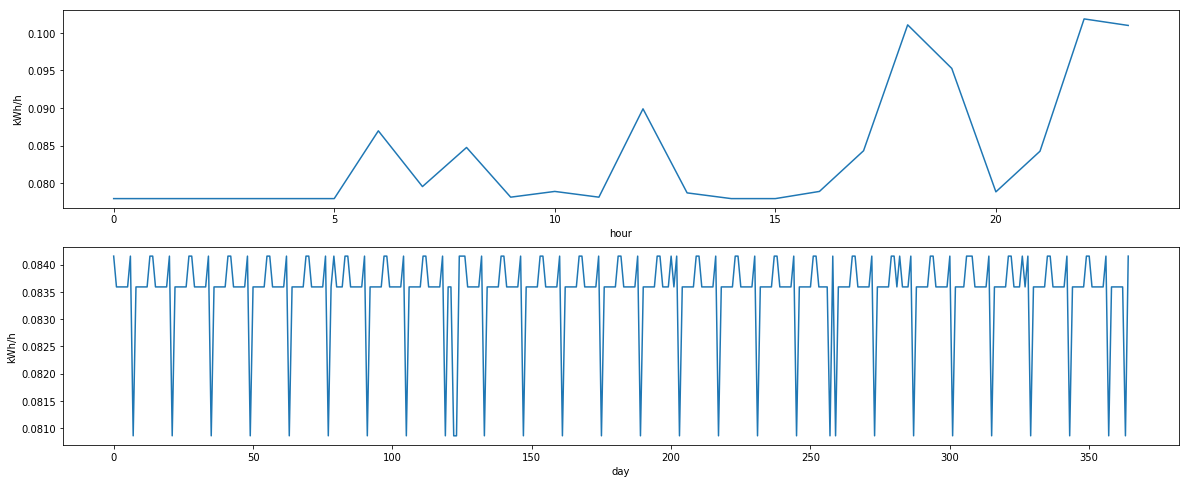

In [14]:
test1_mean_hr = np.mean(testcase1.reshape(365,24),axis=0)
test1_mean_day = np.mean(testcase1.reshape(365,24),axis=1)

fig = plt.figure(figsize=(20,8))
grh1_hr = fig.add_subplot(211)
grh1_hr.plot(test1_mean_hr)
grh1_hr.set_ylabel("kWh/h")
grh1_hr.set_xlabel("hour")

grh1_day = fig.add_subplot(212)
grh1_day.plot(test1_mean_day)
grh1_day.set_ylabel("kWh/h")
grh1_day.set_xlabel("day")
plt.show()

### 計算条件2

In [15]:
n_p = 2.0
A_A = 70.0
V = {
    'type' : 'ダクト式第一種換気設備',
    'input' : '比消費電力',
    'f_SFP' : 0.1,
    'v_e' : 0.9,
    'N' : 2.2,
}
HEX = None
testcase2 = get_E_E_V_d_t(n_p, A_A, V, HEX)

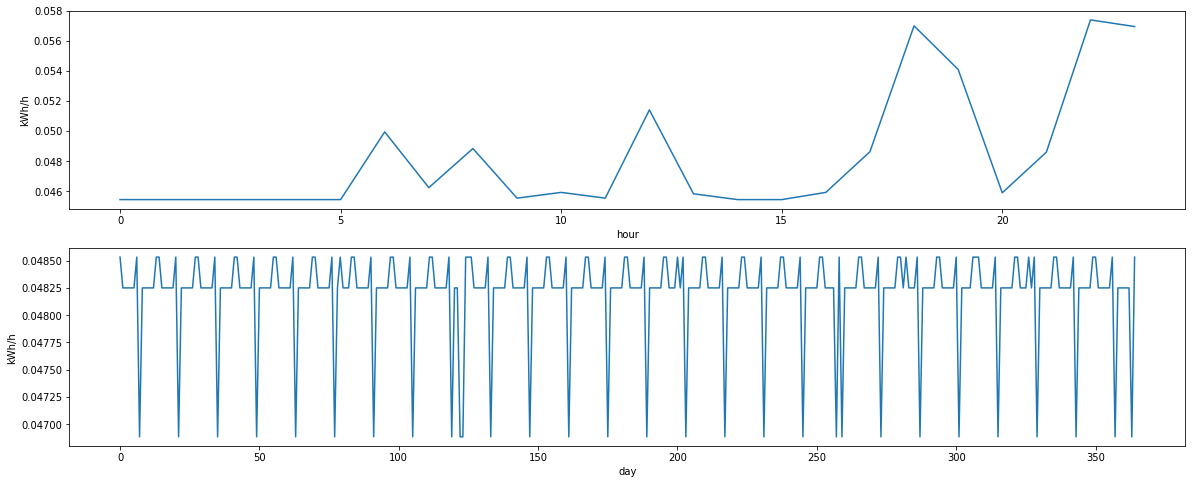

In [16]:
import numpy as np
test2_mean_hr = np.mean(testcase2.reshape(365,24),axis=0)
test2_mean_day = np.mean(testcase2.reshape(365,24),axis=1)

fig = plt.figure(figsize=(20,8))
grh2_hr = fig.add_subplot(211)
grh2_hr.plot(test2_mean_hr)
grh2_hr.set_ylabel("kWh/h")
grh2_hr.set_xlabel("hour")

grh2_day = fig.add_subplot(212)
grh2_day.plot(test2_mean_day)
grh2_day.set_ylabel("kWh/h")
grh2_day.set_xlabel("day")
plt.show()

### 計算条件3

In [17]:
n_p = 4.0
A_A = 120.0
V = {
    'type' : 'ダクト式第二種換気設備又はダクト式第三種換気設備',
    'input' : '比消費電力',
    'f_SFP' : 0.1,
    'v_e' : 0.9,
    'N' : 2.2,
}
HEX = None
testcase3 = get_E_E_V_d_t(n_p, A_A, V, HEX)

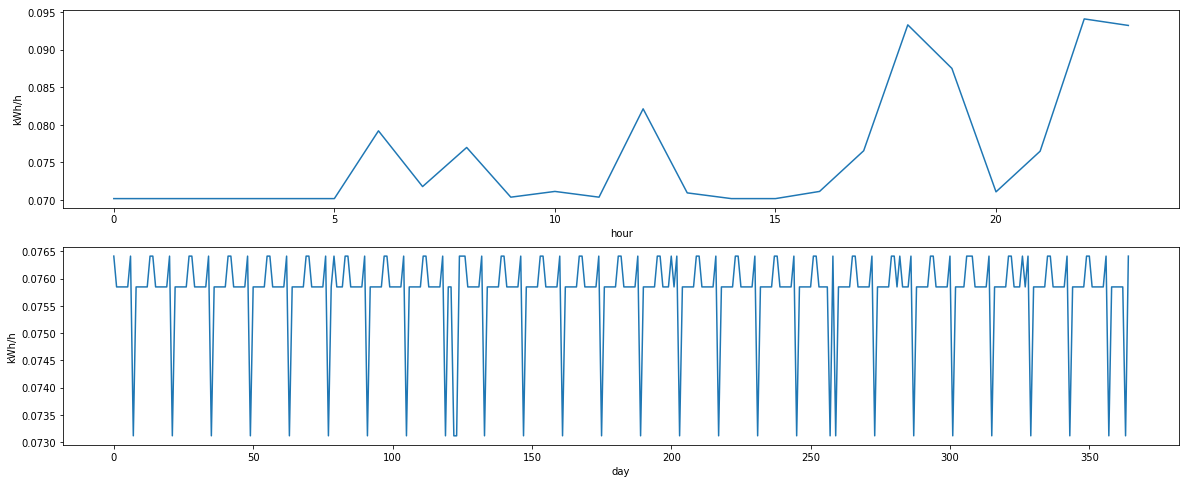

In [18]:
test3_mean_hr = np.mean(testcase3.reshape(365,24),axis=0)
test3_mean_day = np.mean(testcase3.reshape(365,24),axis=1)

fig = plt.figure(figsize=(20,8))
grh3_hr = fig.add_subplot(211)
grh3_hr.plot(test3_mean_hr)
grh3_hr.set_ylabel("kWh/h")
grh3_hr.set_xlabel("hour")

grh3_day = fig.add_subplot(212)
grh3_day.plot(test3_mean_day)
grh3_day.set_ylabel("kWh/h")
grh3_day.set_xlabel("day")
plt.show()

### 計算条件4

In [19]:
n_p = 4.0
A_A = 120.0
V = {
    'type' : 'ダクト式第一種換気設備',
    'input' : '比消費電力',
    'f_SFP' : 0.3,
    'v_e' : 0.9,
    'N' : 2.2,
}
HEX = None
testcase4 = get_E_E_V_d_t(n_p, A_A, V, HEX)

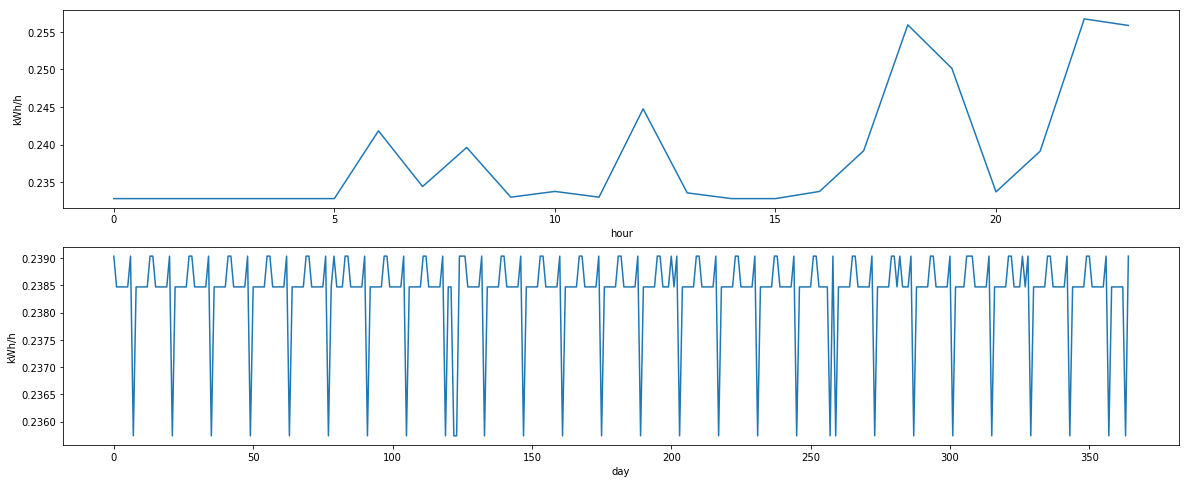

In [20]:
test4_mean_hr = np.mean(testcase4.reshape(365,24), axis=0)
test4_mean_day = np.mean(testcase4.reshape(365,24), axis=1)

fig = plt.figure(figsize=(20,8))
grh4_hr = fig.add_subplot(211)
grh4_hr.plot(test4_mean_hr)
grh4_hr.set_ylabel("kWh/h")
grh4_hr.set_xlabel("hour")

grh4_day = fig.add_subplot(212)
grh4_day.plot(test4_mean_day)
grh4_day.set_ylabel("kWh/h")
grh4_day.set_xlabel("day")
plt.show()


### 計算条件5

In [21]:
n_p = 4.0
A_A = 120.0
V = {
    'type' : 'ダクト式第一種換気設備',
    'input' : '評価しない',
    'f_SFP' : 0,
    'v_e' : 0.9,
    'N' : 2.2,
}
HEX = None
testcase5 = get_E_E_V_d_t(n_p, A_A, V, HEX)

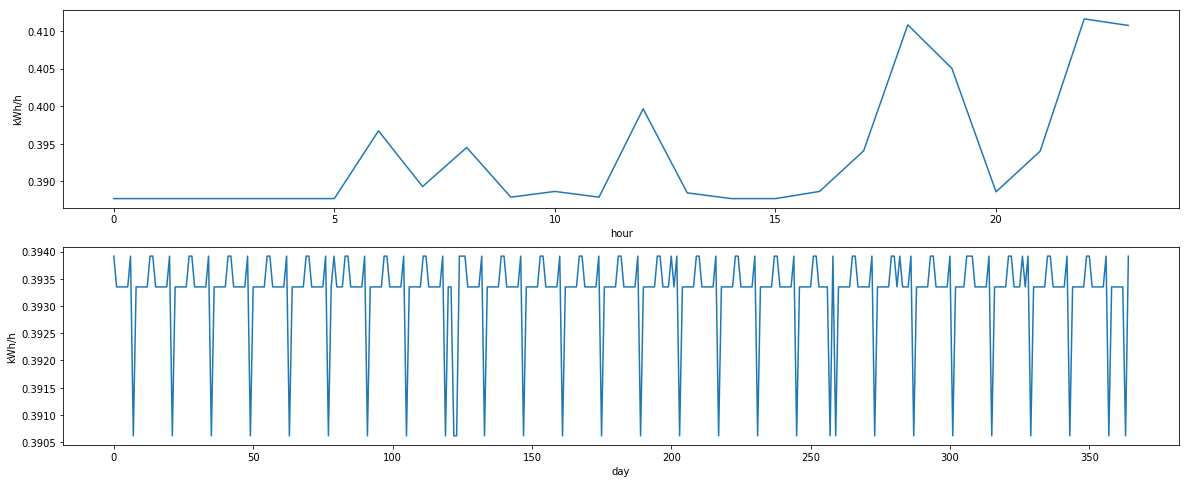

In [22]:
test5_mean_hr = np.mean(testcase5.reshape(365,24), axis=0)
test5_mean_day = np.mean(testcase5.reshape(365,24), axis=1)

fig = plt.figure(figsize=(20,8))
grh5_hr = fig.add_subplot(211)
grh5_hr.plot(test5_mean_hr)
grh5_hr.set_ylabel("kWh/h")
grh5_hr.set_xlabel("hour")

grh5_day = fig.add_subplot(212)
grh5_day.plot(test5_mean_day)
grh5_day.set_ylabel("kWh/h")
grh5_day.set_xlabel("day")
plt.show()


### 計算条件6

In [23]:
n_p = 4.0
A_A = 120.0
V = {
    'type' : 'ダクト式第一種換気設備',
    'input' : '比消費電力',
    'f_SFP' : 0.1,
    'v_e' : 0.6,
    'N' : 2.2,
}
HEX = None
testcase6 = get_E_E_V_d_t(n_p, A_A, V, HEX)

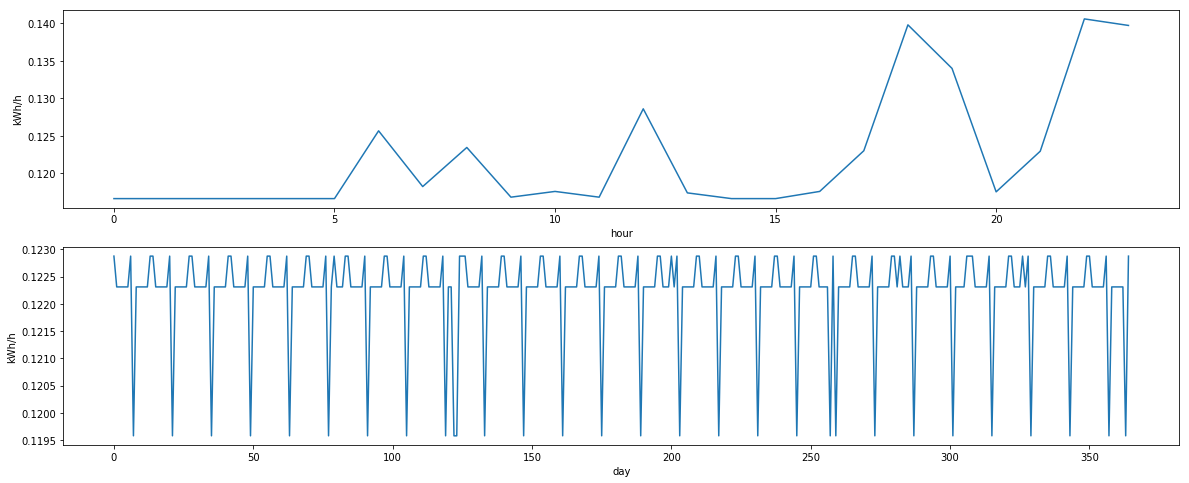

In [24]:
test6_mean_hr = np.mean(testcase6.reshape(365,24), axis=0)
test6_mean_day = np.mean(testcase6.reshape(365,24), axis=1)

fig = plt.figure(figsize=(20,8))
grh6_hr = fig.add_subplot(211)
grh6_hr.plot(test6_mean_hr)
grh6_hr.set_ylabel("kWh/h")
grh6_hr.set_xlabel("hour")

grh6_day = fig.add_subplot(212)
grh6_day.plot(test6_mean_day)
grh6_day.set_ylabel("kWh/h")
grh6_day.set_xlabel("day")
plt.show()


### 計算条件7

In [25]:
n_p = 4.0
A_A = 120.0
V = {
    'type' : 'ダクト式第一種換気設備',
    'input' : '比消費電力',
    'f_SFP' : 0.1,
    'v_e' : 0.9,
    'N' : 3,
}
HEX = None
testcase7 = get_E_E_V_d_t(n_p, A_A, V, HEX)

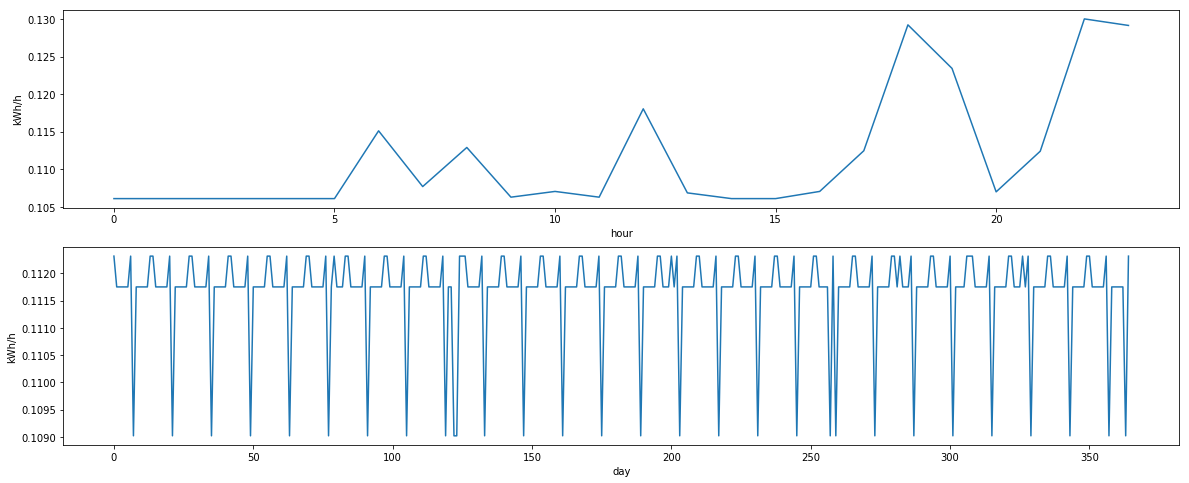

In [26]:
test7_mean_hr = np.mean(testcase7.reshape(365,24), axis=0)
test7_mean_day = np.mean(testcase7.reshape(365,24), axis=1)

fig = plt.figure(figsize=(20,8))
grh7_hr = fig.add_subplot(211)
grh7_hr.plot(test7_mean_hr)
grh7_hr.set_ylabel("kWh/h")
grh7_hr.set_xlabel("hour")

grh7_day = fig.add_subplot(212)
grh7_day.plot(test7_mean_day)
grh7_day.set_ylabel("kWh/h")
grh7_day.set_xlabel("day")
plt.show()


### 比較

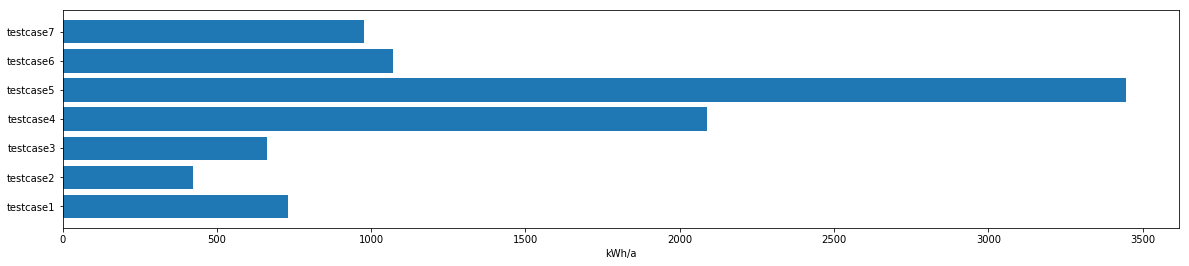

In [27]:
dat = {"testcase1":sum(testcase1),"testcase2" : sum(testcase2), "testcase3" : sum(testcase3), "testcase4" : sum(testcase4),
      "testcase5" : sum(testcase5), "testcase6" : sum(testcase6), "testcase7" : sum(testcase7)}
xx = list(dat.keys())
yy = list(dat.values())

fig = plt.figure(figsize=(20,4))
axt = fig.add_subplot(111)
axt.barh(xx,yy)
axt.set_xlabel("kWh/a")
plt.show()


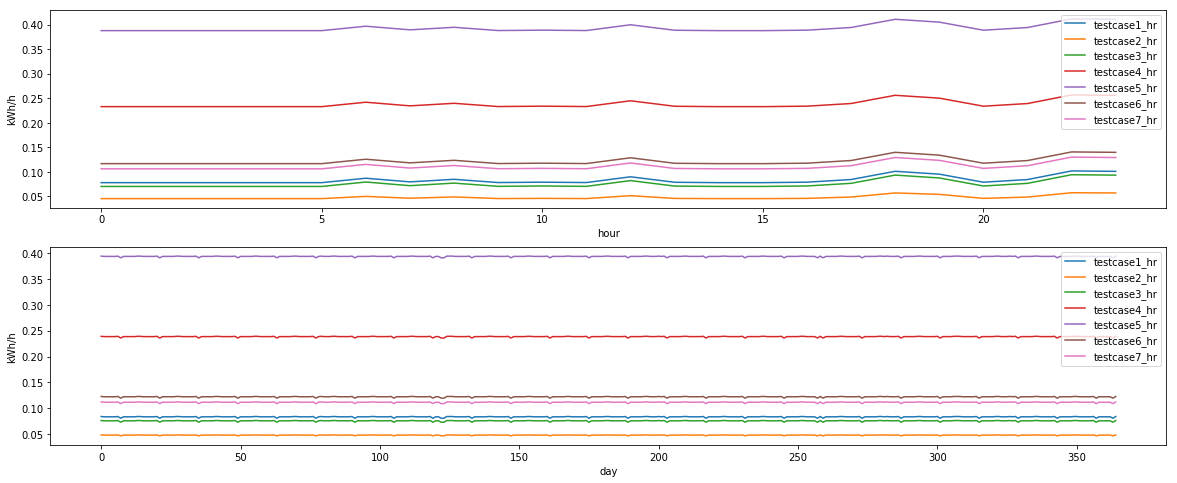

In [28]:
dat_hr = {"testcase1_hr" : test1_mean_hr, "testcase2_hr" : test2_mean_hr, "testcase3_hr" : test3_mean_hr, 
          "testcase4_hr" : test4_mean_hr, "testcase5_hr" : test5_mean_hr, "testcase6_hr" : test6_mean_hr, 
          "testcase7_hr" : test7_mean_hr}
xx_hr = list(dat_hr.keys())

dat_day = {"testcase1_day" : test1_mean_day, "testcase2_day" : test2_mean_day, "testcase3_day" : test3_mean_day,
          "testcase4_day" : test4_mean_day, "testcase5_day" : test5_mean_day, "testcase6_day" : test6_mean_day,
          "testcase7_day" : test7_mean_day}
xx_day = list(dat_day.keys())

fig = plt.figure(figsize=(20,8))
ax_hr = fig.add_subplot(211)
ax_day = fig.add_subplot(212)

for k in dat_hr.keys():
    ax_hr.plot(dat_hr[k])
    
ax_hr.legend(xx_hr)
ax_hr.set_ylabel("kWh/h")
ax_hr.set_xlabel("hour")

for k in dat_day.keys():
    ax_day.plot(dat_day[k])

ax_day.legend(xx_hr)
ax_day.set_ylabel("kWh/h")
ax_day.set_xlabel("day")
plt.show()
